## CIFAR10 CNN Model

In this notebook, we will use PyTorch Convolutional Network to classify the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

Steps are as follows:
- Loading data
- Exploring
- Building the linear model
    - Training
    - Evaluation
    - Confusion Matrix
- Building the CNN model
    - Training
    - Evaluation
    - Confusion Matrix

In [37]:
## first the imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchmetrics.classification import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from pathlib import Path

In [4]:
## making a device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
PATH = '../data/'
PATH_DIR = Path(PATH)
PATH_DIR.mkdir(parents=True, exist_ok = True)

<a name='loading'></a>
### Loading

In [6]:
## we want to download the data into out path
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([.5,.5,.5],[.5,.5,.5])])
train_data = datasets.CIFAR10(root = PATH_DIR,
                              download=True,
                              train=True,
                              transform=transform)
test_data = datasets.CIFAR10(root = PATH_DIR,
                              train=False,
                              transform=transform)
## getting the classes
classes = train_data.classes
## and then we want to create dataloaders from these datasets
## for ease of iterating through them
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_data,
                                           shuffle=True,
                                           batch_size = BATCH_SIZE)

test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size = BATCH_SIZE)
## checking the first batch
first_batch_feat, first_batch_label = next(iter(train_loader))
n_channels = first_batch_feat.shape[1]
input_shape = first_batch_feat.shape[2]
print(first_batch_feat.shape, first_batch_label.shape)

100%|██████████| 170498071/170498071 [00:03<00:00, 56107611.54it/s]


Extracting ..\data\cifar-10-python.tar.gz to ..\data
torch.Size([64, 3, 32, 32]) torch.Size([64])


<a name='exploring'></a>
### Exploring the data

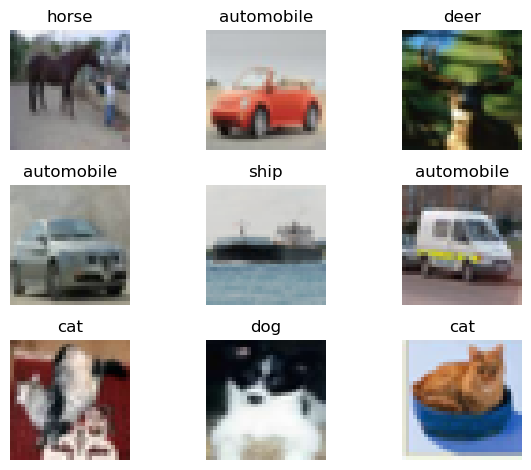

In [7]:
nrows, ncols = 3,3
for i in range(1, 10):
  img, label = first_batch_feat[i], first_batch_label[i]
  img = img/2 +.5
  plt.subplot(nrows, ncols, i)
  plt.imshow(img.permute((1,2,0)))
  plt.title(f'{classes[label.item()]}')
  plt.axis(False)

plt.tight_layout();

<a name='lrmodel'></a>
### Building the linear model

In [ ]:
## we want to use a simple architecture for our first model
class CIFAR10_ClassifierV1(nn.Module):
  def __init__(self, in_channel, input_shape, hidden_units, output_shape):
    """

    This class will take an image and return the label associated with the features.
    in_channel: color channels
    input_shape: shape of input features
    hidden_units: number of hidden neurons
    output_shape: number of classes

    """
    super().__init__()
    self.l1 = nn.Sequential(
        nn.Flatten(1),
        nn.Linear(in_features=in_channel*input_shape*input_shape,
                  out_features=hidden_units),
        nn.ReLU()
    )
    self.l2 = nn.Sequential(
        nn.Linear(in_features=hidden_units,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )
  def forward(self, x:torch.Tensor)->torch.Tensor:
    return self.l2(self.l1(x))

## creating our instance
model_0 = CIFAR10_ClassifierV1(in_channel = n_channels,
                               input_shape = input_shape,
                               hidden_units = 8 ** 2,
                               output_shape = len(classes)).to(device)
## we can now move to loss and optimizer
learning_rate = 1e-2
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr = learning_rate)


<a name='lrmodeltrain'></a>
### Training

In [15]:
## since we will be using multiple models in this notebook
## having a function for training and testing loops can be useful
def training_path(model:nn.Module,
                  data_loader:torch.utils.data.DataLoader,
                  loss_fn: nn.Module,
                  optimizer:torch.optim,
                  device='cpu'):
    """
    This function will take the model and the dataloader
    and train it for each batch of data
    and returns the average loss and accuracy
    """
    running_loss = 0
    running_accuracy = 0
    for features, labels in data_loader:
        features, labels = features.to(device), labels.to(device)
        ## first we need to calculate the predictions
        preds = model(features)
        loss = loss_fn(preds, labels)
        ## storing the loss in the running loss
        running_loss += loss.item()
        running_accuracy += (labels == preds.argmax(1)).sum() / len(features)
        ## zeroing out the gradient
        optimizer.zero_grad()
        ## backpropagation
        loss.backward()
        ## and taking a step
        optimizer.step()
    ## and finally returning the vals
    running_loss, running_accuracy = running_loss/len(data_loader), (running_accuracy/len(data_loader))
    return running_loss, running_accuracy

In [16]:
## and then use the function in our training loop
epochs = 50
loss_dict = {}
for e in range(epochs):
    running_loss, running_accuracy = training_path(model=model_0,
                                                 data_loader = train_loader,
                                                 loss_fn=loss_fn,
                                                 optimizer=optimizer,
                                                 device=device)
    if e%10==0:
        print(f'Epoch: {e} | Running Loss : {running_loss:.4f} | Running Accuracy : {running_accuracy*100:.2f}%')
    loss_dict[e] = running_loss

Epoch: 0 | Running Loss : 1.3551 | Running Accuracy : 51.55%
Epoch: 10 | Running Loss : 1.2830 | Running Accuracy : 53.69%
Epoch: 20 | Running Loss : 1.2651 | Running Accuracy : 54.54%
Epoch: 30 | Running Loss : 1.2404 | Running Accuracy : 55.31%
Epoch: 40 | Running Loss : 1.2277 | Running Accuracy : 55.73%


<a name='lrmodelevaluate'></a>
### Evaluation

In [22]:
## the evaluation function
def evaluating_path(model:nn.Module,
                    data_loader=torch.utils.data.DataLoader,
                    loss_fn=nn.Module,
                    device='cpu'):
    ## first putting the model in eval state
    model.eval()
    ## and using the inference mode
    ## to turn off the gradient 
    with torch.inference_mode():
        running_loss = 0
        running_accuracy = 0
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)
            preds = model(features)
            loss = loss_fn(preds, labels)
            running_loss += loss.item()
            running_accuracy += (preds.argmax(1) == labels).sum() / len(features)
        running_loss /= len(data_loader)
        running_accuracy /= len(data_loader)
        return running_loss, running_accuracy

In [23]:
## and using the function to evaluate the model
running_loss, running_accuracy = evaluating_path(model=model_0,
                                             data_loader = test_loader,
                                             loss_fn=loss_fn,
                                             device=device)
print(f'Evaluation Results | Running Loss : {running_loss:.4f} | Running Accuracy : {running_accuracy*100:.2f}%')

Evaluation Results | Running Loss : 2.1596 | Running Accuracy : 41.35%


### Confusion Matrix

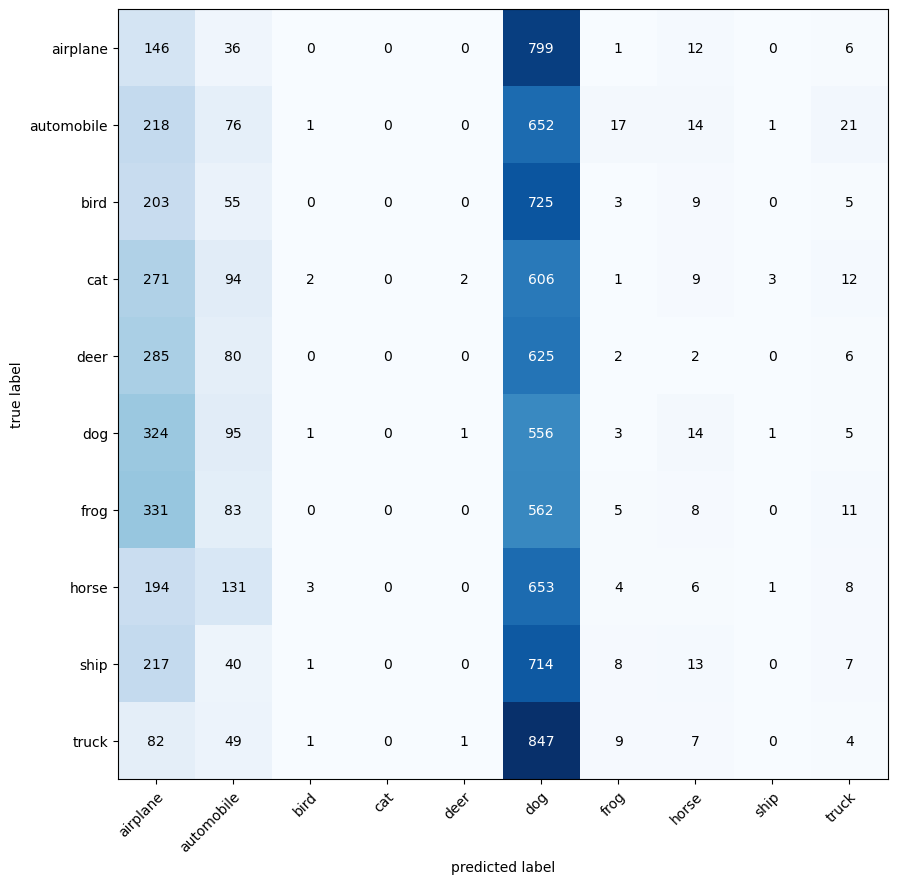

In [40]:
## we want to check the classes that our model is getting wrong
conf_mat = ConfusionMatrix(task='multiclass',num_classes = len(classes))
model_0.eval()
with torch.inference_mode():
    preds = model_0(torch.tensor(test_data.data,dtype=torch.float)).argmax(1)
confusion = conf_mat(preds=preds, target=torch.tensor(test_data.targets,dtype=torch.float))

fig, ax = plot_confusion_matrix(
    confusion.numpy(),
    class_names =classes,
    figsize=(10, 10),
    cmap='Blues'
)

Our Linear model didn't perform that well, as expected. Now we can move on to using **Convolutional Neural Network**.

### Building the CNN model

In [ ]:
## for this model we will be using CNN
class CIFAR10_ClassifierV2(nn.Module):
    def __init__(self, in_channel, input_shape, output_shape, hidden_units = 64):
        """

    This class will take an image and return the label associated with the features.
    in_channel: color channels
    input_shape: shape of input features
    hidden_units: number of hidden neurons - 64 by default
    output_shape: number of classes

    """
        super().__init__()
        
        